## Frequency Analysis with Power weights

1. Solve convolution equation get positive power weight
2. If power weight is not good for identifying peaks. (Higher $n$ or $\alpha$)
    1. Raise sampling rate but not high frequncy dominantly
    2. Cutting signal through low pass filter $f_{b} = {2\pi}/W$

$n_{lim}$: bounary sampling number of the higher frequncy is 1 or less.

Power weight allocation: 

    * Source distribution: high freqency or low frequncy peaks
    
    * Power mapping: Enveloping signal

Source distribution: 


In [1]:
import os, sys
sys.path.insert(1, os.getcwd()) 
sys.path.append("..")

In [2]:
from uilc import PositionArray
from uilc.methods import pw
from uilc.utils.radiation import lambertian_convolve_1d
from uilc.utils.convolution import convolve2d

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq, ifft
from copy import deepcopy

---
Start

In [4]:
#Optical system setting
cm = 1E-2
s = 20
alpha = np.array([2.5, 3]) # W/H
H = 0.1*cm
W = alpha * H
print("System parameters:=========")
print("Lambertian:", s)
print("Ratio, x, y:", alpha)
print(f"H:{H}, W:{W}")

System parameters:=========
Lambertian: 20
Ratio, x, y: [2.5 3. ]
H:0.001, W:[0.0025 0.003 ]


$$K * \Rho = I$$

Suppose that $\Rho$ is separable such that $\rho_x * \rho_y = \Rho$. Since $K$ is centrosymmetric matrix, can be decomped to 2 convolution.

$$K = k_x * k_y$$

where, $k_x^t = k_y$.

$$(k_x * k_y) * (\rho_x * \rho_y) = I $$

$$(k_x * \rho_x) * (k_y * \rho_y) = I $$

1 dim convolution can be transformed to Hermit Toeplitz matrix product.

$$(K_x \cdot \rho_x) * (K_y \cdot \rho_y)^t = I $$

In [5]:
nmax = (pw.nmax(s, W[0], H), pw.nmax(s, W[1], H))
print("Max dimension for positive solution of each x, y axes.")
print(nmax)

Max dimension for positive solution of each x, y axes.
(12, 14)


In [6]:
n, m = nmax
n += 3
m += 3

In [7]:
# X direction
weights_x, position_x = pw.power_weight(s, W[0], H, dim =n ,set_nmax = False)
# Y direction
weights_y, position_y = pw.power_weight(s, W[1], H, dim =m ,set_nmax = False)

In [8]:
wx = (weights_x+ np.flip(weights_x))/2
wy = (weights_y+ np.flip(weights_y))/2

In [9]:
X, Y = np.meshgrid(position_x, position_y)
Z = convolve2d(wx.reshape(1, -1), wy.reshape(-1, 1))

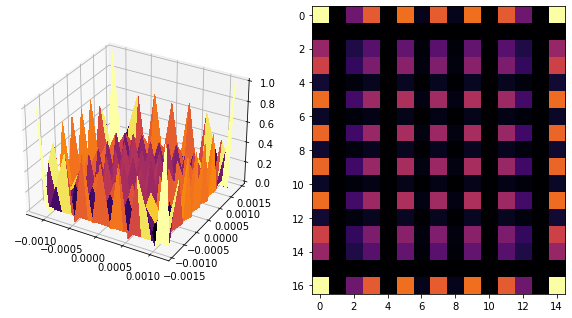

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2, 1,projection='3d')
ax.plot_surface(X, Y, Z/Z.max(), rstride=1, cstride=1, cmap="inferno",
                       linewidth=0, antialiased=False, shade=False)
ax2 = fig.add_subplot(1,2, 2)
ax2.imshow(Z/Z.max(), cmap="inferno",)
plt.show()

In [11]:
n, m = nmax
n += 100
m += 100
# X direction
weights_x, position_x = pw.power_weight(s, W[0], H, dim =n ,set_nmax = False)
# Y direction
weights_y, position_y = pw.power_weight(s, W[1], H, dim =m ,set_nmax = False)
wx = (weights_x+ np.flip(weights_x))/2
wy = (weights_y+ np.flip(weights_y))/2
X, Y = np.meshgrid(position_x, position_y)
Z = convolve2d(wx.reshape(1, -1), wy.reshape(-1, 1))

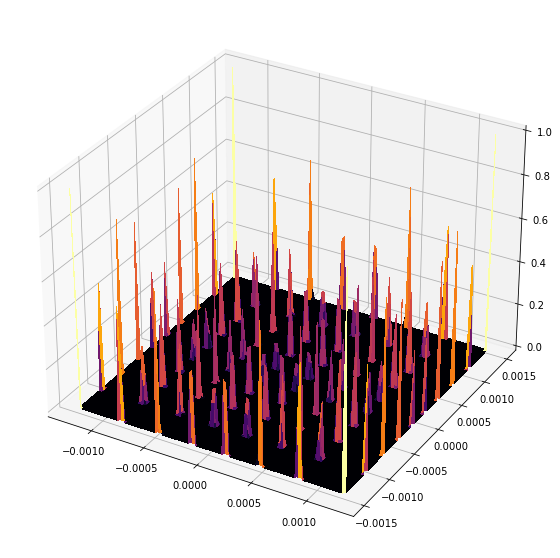

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1, 1,projection='3d')
ax.plot_surface(X, Y, Z/Z.max(), rstride=1, cstride=1, cmap="inferno",
                       linewidth=0, antialiased=False, shade=False)
#ax2 = fig.add_subplot(1,2, 2)
#ax2.imshow(Z/Z.max(), cmap="inferno",)
plt.show()

2D convolution

In [13]:
print("System parameters:=========")
print("Lambertian:", s)
print("Ratio, x, y:", alpha)
print(f"H:{H}, W:{W}")

System parameters:=========
Lambertian: 20
Ratio, x, y: [2.5 3. ]
H:0.001, W:[0.0025 0.003 ]


In [14]:
from uilc.utils import radiation
from uilc.utils.misc import csym_index
import uilc.utils.convolution as convolution
from scipy.optimize import nnls, lsq_linear

In [15]:
#Optical system setting
cm = 1E-2
s = 11
alpha = np.array([2, 3]) # W/H
H = 0.1*cm
W = alpha * H

In [34]:
dr =  W[1]/ W[0]
#n,m = nmax
m = 40
n = int(m * 1/dr)
dx = W[0]/n
dy = W[1]/m
l = 2*n -1
k = 2*m - 1

In [35]:
r0 = np.array([dx*n,dy*m])
r1  = lambda i, j: np.array([dx*(i+1), dy*(j+1)])

In [36]:
def lambertian2d(r0, r1, s, H):
    if len(r1.shape) >=3 and r1.shape[0] ==2:
        row = r1[0]
        column = r1[1]

        r_v = r0[0] * np.ones(shape=row.shape)
        c_v = r0[1] * np.ones(shape=column.shape)

        k = (np.power(row - r_v, 2) + np.power(column-c_v, 2))/(H**2)
    else:
        k = np.linalg.norm(r0-r1)/H**2
        
    base = (H**2)*(1 + k**2)**(s/2 +1)
    return np.power(base, -1)

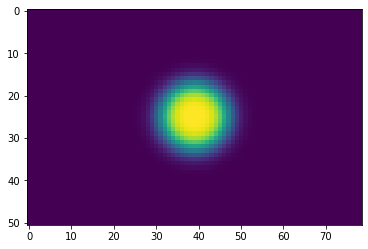

In [37]:
filter=np.fromfunction(
    lambda i, j: lambertian2d(r0, r1(i,j), s, H), 
    (l,k), dtype=float)
plt.imshow(filter)

In [38]:
def pos_n(i, j, n, m, dx ,dy):
    return (dx*(n-i))**2 + (dy*(m-j))**2

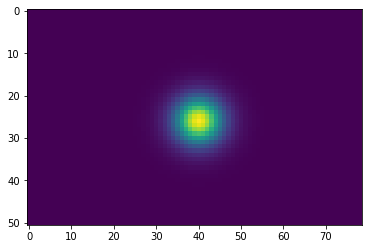

In [39]:
filter2=np.fromfunction(
    lambda i, j: radiation.lambertian(0, np.sqrt(pos_n(i, j, n, m, dx ,dy)), s, H), 
    (l,k), dtype=float)
plt.imshow(filter2)

In [40]:
#filter=np.fromfunction(
#    lambda i, j: radiation.lambertian(0, np.sqrt(pos_n(i, j, l, k, dx ,dy)), s, H), 
#    (l,k), dtype=float)
A = convolution.get_matrix_system(filter2, (n, m))
A = A/A.max()
if np.fabs(np.linalg.det(A)) < 1E-100000:
    print("Unsolvable")
else: 
    dim_l = A.shape[0]
    const = np.ones(shape=(dim_l,))
    sol = nnls(A, const)[0]

In [41]:
#sol2 = lsq_linear(A, const, bounds=(0, 10), method='trf')
#plt.imshow(sol2.x.reshape(n, m))

In [42]:
def get_sym_sol(sol):
    sol1 = sol
    sol2 = np.flip(sol1)
    sol3 = np.flip(sol1, axis =1)
    sol4 = np.flip(sol2, axis =1)
    return (sol1 + sol2 + sol3 + sol4)/4

In [43]:
sol_f = get_sym_sol(sol.reshape(n,m))
X_2d, Y_2d = np.meshgrid(dx*csym_index(l), dy*csym_index(k))

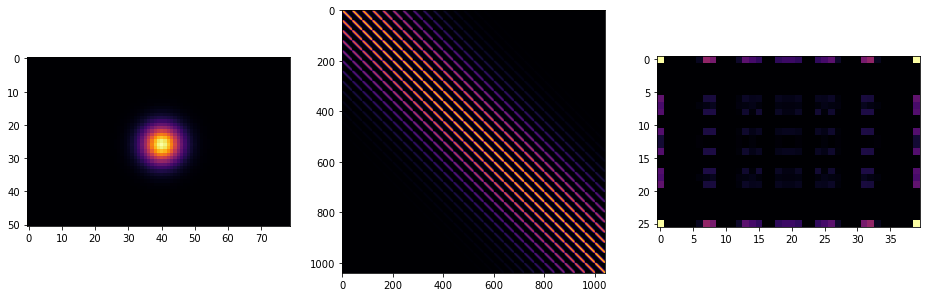

In [44]:
fig =plt.figure(figsize=(16,16))

axes = [fig.add_subplot(1,3 ,1),
fig.add_subplot(1,3 ,2),
fig.add_subplot(1,3 ,3)]

axes[0].imshow(filter2, cmap ='inferno')
axes[1].imshow(A, cmap ='inferno')
axes[2].imshow(sol_f/sol_f.max(), cmap ='inferno')
plt.show()

In [45]:
test = sol_f/sol_f.max()
a, b = test.shape
print((W[0]*W[1])*test.sum()/(a*b))

1.3432830231779797e-07


In [46]:
test /= (1)*test.sum()/(a*b)

In [50]:
test *= (24/1040) 

In [51]:
test

array([[1.03076966, 0.        , 0.        , ..., 0.        , 0.        ,
        1.03076966],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.03076966, 0.        , 0.        , ..., 0.        , 0.        ,
        1.03076966]])

In [411]:
from scipy.ndimage import convolve

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (39, 25) and arg 2 with shape (39, 59).

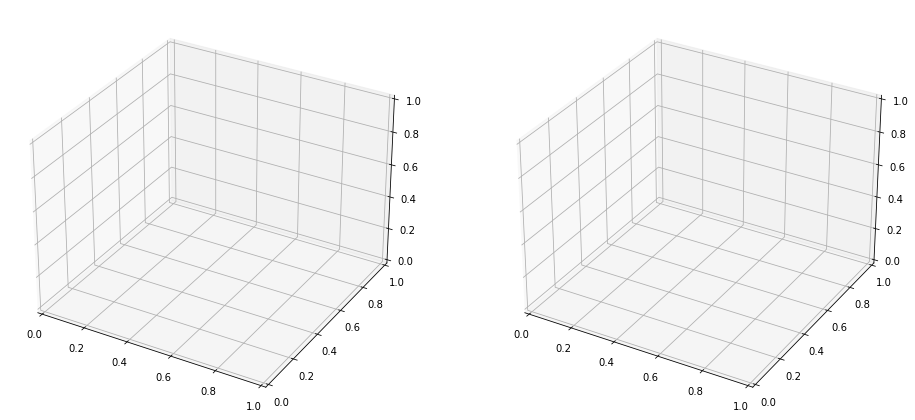

In [429]:
X_2d, Y_2d = np.meshgrid(dx*csym_index(l), dy*csym_index(k))
x_2d, y_2d = np.meshgrid(dx*csym_index(n), dy*csym_index(m))
fig, axis = plt.subplots(1,2, figsize =(16,16),subplot_kw={"projection":'3d'})
axis[0].plot_surface(X_2d, Y_2d, z_plot.transpose(), cmap='inferno',
                       linewidth=2, antialiased=True, shade=True)
axis[1].plot_surface(x_2d, y_2d, 2*(sol_f/sol_f.max()).transpose(),
                       cmap="inferno")
plt.show()

In [438]:
z_data = convolution.convolve2d(filter,sol_f, crop=(n,m))
z_data /= z_data.max()
print(f"Mean:{z_data.mean()}, Min/Max:{z_data.min()}, std/Max:{z_data.std()}")

Mean:0.8768316105192365, Min/Max:0.6261064718656698, std/Max:0.07728351599295352


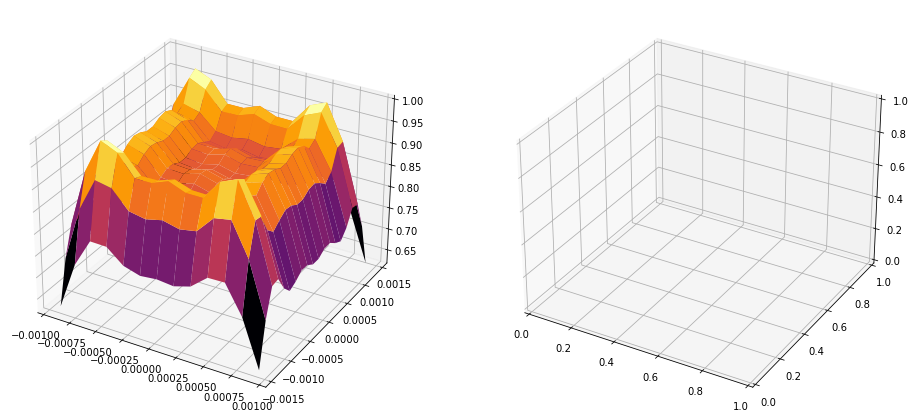

In [439]:
fig, axis = plt.subplots(1,2, figsize =(16,16),subplot_kw={"projection":'3d'})
nd, md = z_data.shape
x_2d, y_2d = np.meshgrid(dx*csym_index(nd), dy*csym_index(md))
axis[0].plot_surface(x_2d, y_2d, z_data.transpose(), cmap='inferno',
                       linewidth=2, antialiased=True, shade=True)
#axis[1].plot_surface(x_2d, y_2d, 2*(sol_f/sol_f.max()).transpose(),
#                       cmap="inferno")
plt.show()

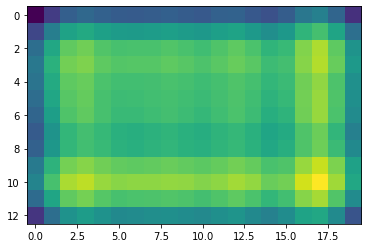

In [437]:
plt.imshow(z_data)

In [177]:
A2 = convolution.get_matrix_system(sum_filter, (n, m))
if np.fabs(np.linalg.det(A2)) < 1E-100000:
    print("Unsolvable")
else: 
    dim_l = A2.shape[0]
    const = np.ones(shape=(dim_l,))
    sol2 = nnls(A2, const)[0]
X_2d, Y_2d = np.meshgrid(dx*csym_index(l), dy*csym_index(k))

c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\numpy\linalg\linalg.py:2146: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


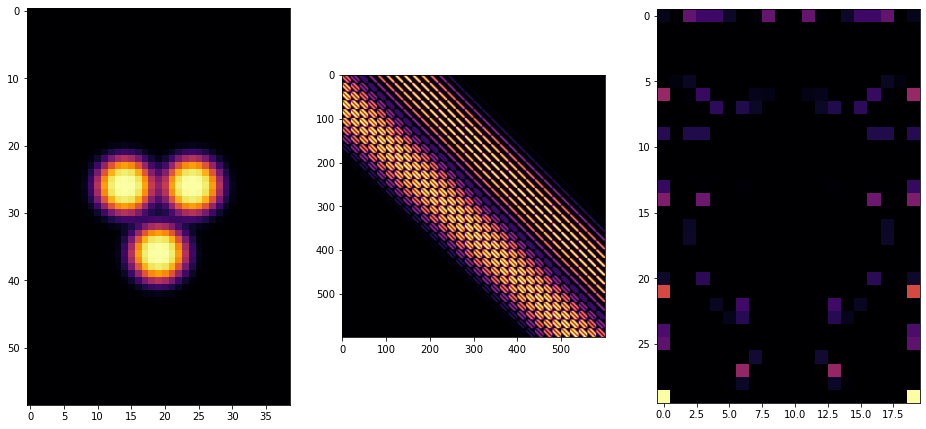

In [178]:
fig =plt.figure(figsize=(16,16))

axes = [fig.add_subplot(1,3 ,1),
fig.add_subplot(1,3 ,2),
fig.add_subplot(1,3 ,3)]

axes[0].imshow(sum_filter, cmap ='inferno')
axes[1].imshow(A2, cmap ='inferno')
axes[2].imshow(sol2.reshape(n, m), cmap ='inferno')
plt.show()

In [179]:
sol2_m = sol2.reshape(n,m)
sol_f2 = get_sym_sol(sol2_m)

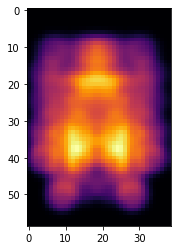

In [180]:
z_plot = convolve(sum_filter, sol2_m)
plt.imshow(z_plot, cmap="inferno")

In [181]:
z_data = z_plot
#z_data = z_data[10:, 1:]
z_data /= z_data.max()
print(f"Mean:{z_data.mean()}, Min/Max:{z_data.min()}, std/Max:{z_data.std()}")

Mean:0.34219192212435096, Min/Max:4.14426324509873e-08, std/Max:0.2811120738282987


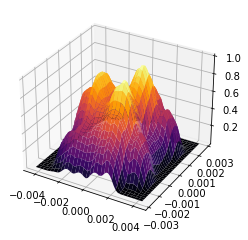

In [183]:
fig, axis = plt.subplots(1,1, subplot_kw={"projection":'3d'})
axis.plot_surface(X_2d, Y_2d, z_plot.transpose(), cmap='inferno',
                       linewidth=2, antialiased=True, shade=True)

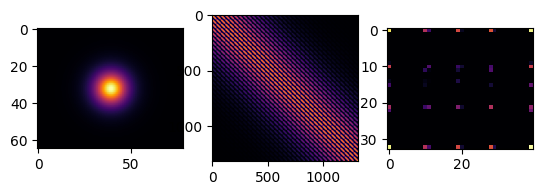

In [502]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(filter, cmap ='inferno')
axes[1].imshow(A, cmap ='inferno')
axes[2].imshow(sol.reshape(n, m), cmap ='inferno')
plt.show()

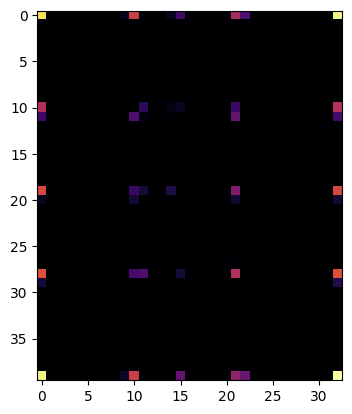

In [503]:
plt.imshow(sol.reshape(n, m).transpose(), cmap='inferno')

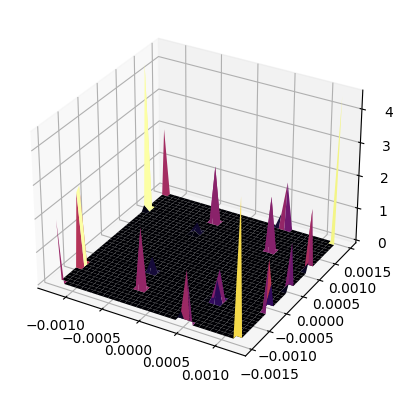

In [504]:
fig, axis = plt.subplots(1,1, subplot_kw={"projection":'3d'})
axis.plot_surface(X_2d, Y_2d, sol2.reshape(n, m).transpose(), cmap='inferno',
                       linewidth=2, antialiased=True, shade=True)

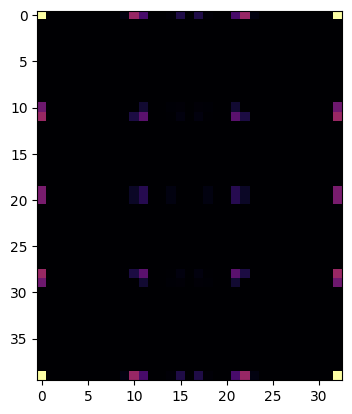

In [505]:
sol1 = sol.reshape(n, m)
sol2 = np.flip(sol1, axis=0)
sol3 = np.flip(sol1, axis=1)
sol4 = np.flip(sol2, axis=1)

sol_f = ((sol1 + sol2 + sol3 +sol4)/4).transpose()
plt.imshow(sol_f/sol_f.max(), cmap='inferno')

In [436]:
from uilc.utils.misc import csym_index

In [437]:
csym_index(n)

array([-16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,
        -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,
         6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.])

In [438]:
X_2d, Y_2d = np.meshgrid(dx*csym_index(n), dy*csym_index(m))
Z_2d = sol_f

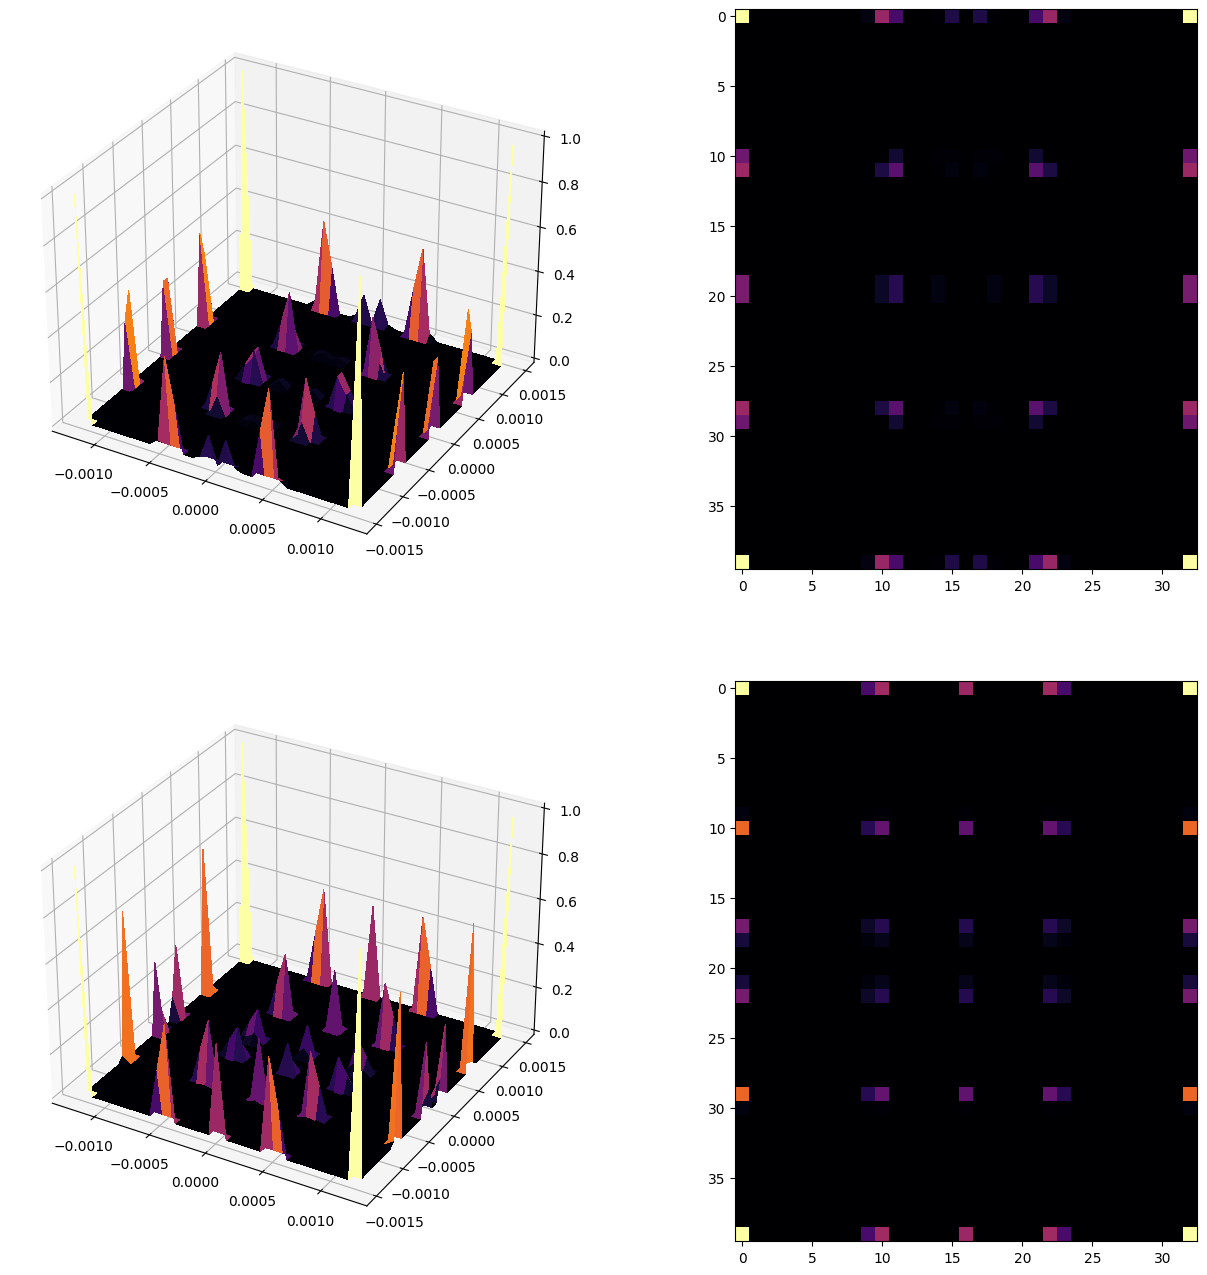

In [439]:
cmap ='inferno'

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(2,2, 1,projection='3d')
ax.plot_surface(X_2d, Y_2d, Z_2d/Z_2d.max(), rstride=1, cstride=1, cmap=cmap,
                       linewidth=0, antialiased=False, shade=False)
ax2 = fig.add_subplot(2,2, 2)
ax2.imshow(Z_2d/Z_2d.max(), cmap=cmap,)
ax3 = fig.add_subplot(2,2, 3,projection='3d')
ax3.plot_surface(X, Y, Z/Z.max(), rstride=1, cstride=1, cmap=cmap,
                       linewidth=0, antialiased=False, shade=False)
ax4 = fig.add_subplot(2,2, 4)
ax4.imshow(Z/Z.max(), cmap=cmap,)
plt.show()

---

## Frequncy modulating

Resampling

In [60]:
resam_x, resam_xt = pw.resample_n(position_x, weights_x, 5, 80)
sig_low_x, sig_high_x = pw.signal_decomposition(resam_xt, resam_x, 1.8*np.pi/W[0], return_type=True)
resam_y, resam_yt = pw.resample_n(position_y, weights_y, 5, 80) 
sig_low_y, sig_high_y = pw.signal_decomposition(resam_yt, resam_y, 1.8*np.pi/W[0], return_type=True)

In [61]:
sig_m = sig_low_x * sig_high_x

(0.059056565980188123+0j)


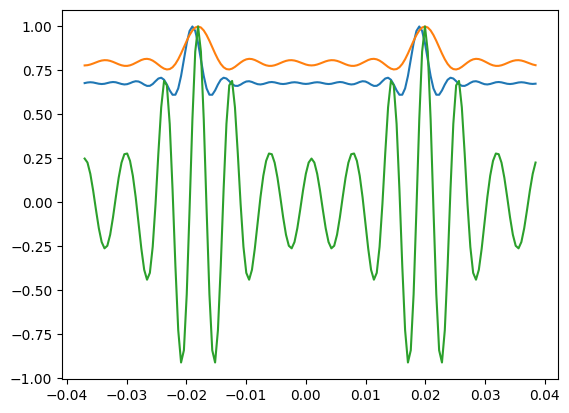

In [62]:
print(sig_high_x.max()/sig_low_x.max())

plt.plot(resam_xt, resam_x/ resam_x.max())
plt.plot(resam_xt, sig_low_x/ sig_low_x.max())
plt.plot(resam_xt, sig_high_x/ sig_high_x.max())


(0.12106806294517501+2.0628690856001255e-33j)


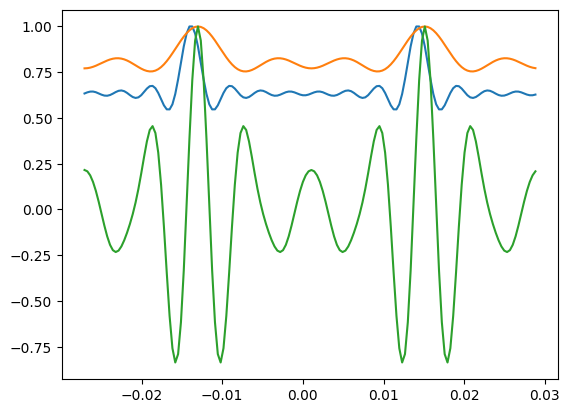

In [63]:
print(sig_high_y.max()/sig_low_y.max())
plt.plot(resam_yt, resam_y/ resam_y.max())
plt.plot(resam_yt, sig_low_y/ sig_low_y.max())
plt.plot(resam_yt, sig_high_y/ sig_high_y.max())

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(position_x, weights_x/weights_x.max())
ax1.set_title("X direction")
ax2.plot(position_y, weights_y/weights_y.max())
ax2.set_title("Y direction")
plt.show()

In [242]:
n = pw.nlimt(s, W, H) +25

In [243]:
power_weight, pos = pw.power_weight(s, W, H, dim=n, set_nmax=False)
power_weight = power_weight/power_weight.max()
x, sig_low_f, sig_high_f = pw.get_signal_decomposition(n, s, W, H, ext_n=10, rate= 480)

sig_ext, pos_ext = pw.resample_n(pos, power_weight, 5, rate=240)
sig_low, sig_high = pw.signal_decomposition(pos_ext, sig_ext, 2*np.pi/W, return_type=True)
t_low, sig_low = pw.signal_cutting(pos_ext, sig_low, [-W/2-W/100 , W/2+W/100])


In [244]:
len(np.where(sig_high_f >sig_low_f[2:].max()*0.01)[0])

12

In [245]:
sig_max = sig_ext.max()
index_peaks, _ = signal.find_peaks(sig_ext, height = 0.95*sig_max)

In [246]:
index_peaks

array([117, 357], dtype=int64)

c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


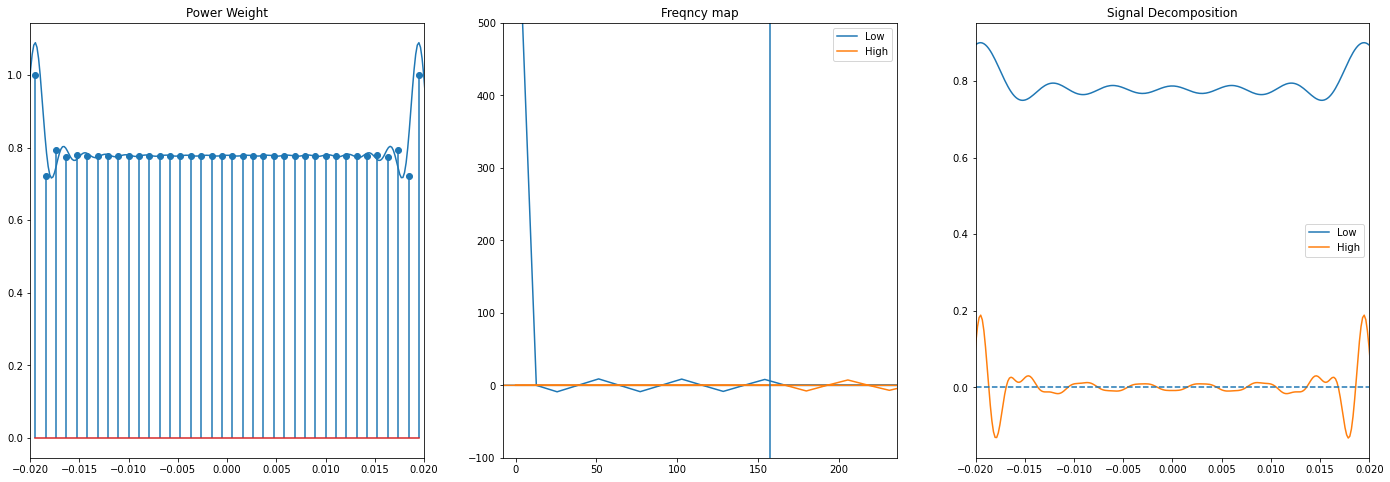

In [247]:
fig = plt.figure(figsize=(24,8))
axe_weight      = fig.add_subplot(1,3,1)
axe_frequency   = fig.add_subplot(1,3,2)
axe_resample    = fig.add_subplot(1,3,3)
#axe1
axe_weight.stem(pos, power_weight)
axe_weight.plot(pos_ext, sig_ext)
axe_weight.set_title("Power Weight")
axe_weight.set_xlim([-W/2, W/2])
#axe2
axe_frequency.plot(x, sig_low_f)
axe_frequency.plot(x, sig_high_f)
axe_frequency.legend(["Low", "High"])
axe_frequency .set_title("Freqncy map")
axe_frequency.axvline(x= 2*np.pi/W)
axe_frequency.set_xlim([-0.1*np.pi/W, 3*np.pi/W])
axe_frequency.set_ylim([-100, 500])

#axe3
axe_resample.plot(t_low, sig_low)
axe_resample.plot(pos_ext, sig_high)
axe_resample.legend(["Low", "High"])
axe_resample.set_title("Signal Decomposition")
axe_resample.set_xlim([-W/2, W/2])
axe_resample.axhline(y = 0, linestyle="--")

plt.show()


Find $n$ such that low frequencies are dominant in power weight.

In [248]:
index, _ = signal.find_peaks(sig_low.real)
sources_low = t_low[index]

In [249]:
#---------------------------------------------
center_h = sig_low.real[index[1:-1]].mean()
boundary_h = sig_low.real[index[0]]
ratio = boundary_h/center_h
print(ratio)

1.1386095536182772


In [250]:
from uilc.methods.esc import coefficient
from uilc.utils.radiation import lambertian

In [251]:
d = coefficient(s, 2)[0]*H

In [252]:
def get_2source_ratio(d, s, H):
    v2 = (lambertian(-d/2, 0, s, H) + lambertian(d/2, 0, s, H))
    v1 = lambertian(0, 0, s, H)
    return v2/v1
def d_points(d, c1, c2):
    dt = d/2
    return [c1-dt, c1+dt, c2-dt, c2+dt]

In [253]:
get_2source_ratio(1.10*d, s, H)

1.1089303285367187

In [254]:
c1 = sources_low[0]
c2 = sources_low[-1]

Mean, Max, Min/Max, std/Max
0.9518, 1.0000, 0.9238, 0.0192


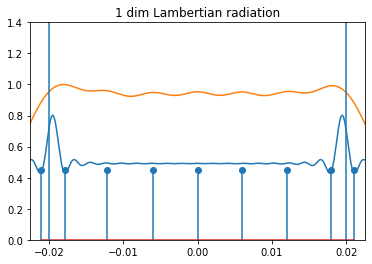

In [263]:
sources = np.append(sources_low[1:-1], d_points(2.5*d, c1, c2))

plane_x = np.linspace(-W/2, W/2, 400, endpoint=True)
plane_x2 = np.linspace(-W, W, 600, endpoint=True)
y_rad = lambertian_convolve_1d(plane_x, sources, s, H)
y_rad = y_rad/y_rad.max() 
y_rad2 = lambertian_convolve_1d(plane_x2, sources, s, H)
y_rad2 =  y_rad2/y_rad2.max()


fig2 = plt.figure()
ax = fig2.add_subplot()
ax.plot(pos_ext, sig_ext-0.4*sig_ext.min())
ax.stem(sources, np.zeros(len(sources))+0.45)

ax.plot(plane_x2, y_rad2/y_rad2.max())

ax.axvline(x= W/2)
ax.axvline(x= -W/2)
ax.set_ylim([0, 1.4])
ax.set_xlim([-W/2 -2*d, W/2+2*d])
ax.set_title("1 dim Lambertian radiation")

print("Mean, Max, Min/Max, std/Max")

ma = y_rad.max()

print(f"{y_rad.mean():.4f}, {ma:.4f}, {y_rad.min()/ma:.4f}, {y_rad.std()/ma:.4f}")

Great

---

$$\exists  f_{high},  ||f_{high}|| <2$$

Exists: only one or two
(peaks + 2) if n =4 then n=2

c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


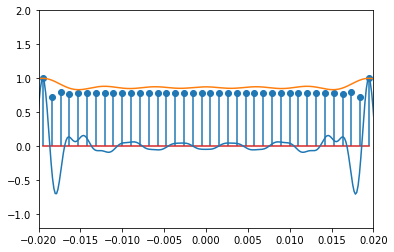

In [267]:
fig = plt.figure()
ax = fig.add_subplot()
ax.stem(pos, power_weight.real/(power_weight.real).max())
ax.plot(pos_ext, sig_high.real/(sig_high.real).max())

ax.plot(t_low, sig_low.real/sig_low.max())

#ax.plot(pos_ext, sig_ext/sig_ext.max())
ax.set_xlim([-W/2, W/2])
ax.set_ylim([-1.2, 2])
plt.show()

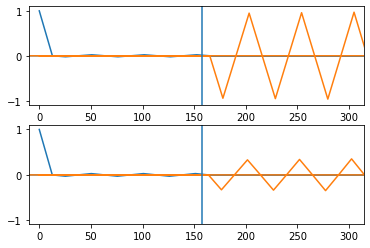

In [268]:
#ns = [nmax, int(1.5*nmax), int(3*nmax), int(4*nmax), int(6*nmax)]
ns  = [nmax, 2*nmax]
plot_data = [pw.get_signal_decomposition(n, s, W, H, ext_n=20, rate =240) for n in ns]
fig = plt.figure()
row = len(plot_data)
for i, (xf, sig_low, sig_high) in enumerate(plot_data):
    ax = fig.add_subplot(row, 1, i+1)
    ax.plot(xf, sig_low/sig_low.max())
    ax.plot(xf, sig_high/sig_high.max())
    ax.set_xlim([-10, 4*np.pi/(W)])
    ax.axvline(2*np.pi/W)
L = [1, 2, 3, 6]
#for n in L:
#    ax.axvline(2*np.pi/(n*W))

#ax.axvline(np.pi/W)
plt.show()

In [269]:
n =ns[0]
sig, time =pw.power_weight(s, W, H, dim=n, set_nmax=False)
sig_low, sig_high = pw.signal_decomposition(time, sig, 2*np.pi/W)

c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Hyunseong\miniconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 2.0)

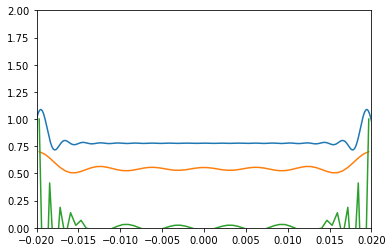

In [271]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(pos_ext, sig_ext)
ax.plot(time, 0.7*(sig_low/sig_low.max()))
ax.plot(time, sig_high/sig_high.max())
#ax.stem(xarr, yarr)
ax.set_xlim([-W/2, W/2])
ax.set_ylim([0, 2])

In [272]:
si_low, si_high = pw.signal_decomposition(sig_ext, pos_ext, 2*np.pi/W)

In [273]:
delta, pos = pw.power_weight(s, W, H, dim = int(2*nmax), set_nmax=False)
si, t = pw.resample_n(delta, pos, 5)
si_low, si_high = pw.signal_decomposition(si, t, 2*np.pi/W)
si_low = si_low.real
si_high = si_high.real
index, _ = signal.find_peaks(si_low)


In [179]:
from scipy.signal import find_peaks

In [180]:
t_in = np.where(t <W/2)
t_sample = t[t_in]
sig_low = si_low[t_in]
sig_high = si_high[t_in]

t_in2 = np.where(-W/2< t_sample)
t_sample = t_sample[t_in2]
sig_low = sig_low[t_in2]
sig_high = sig_high[t_in2]

In [181]:
index_s_low = find_peaks(sig_low)[0]
index_s_high = find_peaks(sig_high)[0]

In [182]:
index_s_low

array([ 36,  73, 110, 147, 184, 221, 257, 291, 325, 359, 394, 428, 462],
      dtype=int64)

In [183]:
s_arr_low = t_sample[index_s_low]
s_arr_high = t_sample[index_s_high]

In [189]:
from uilc.utils.radiation import lambertian_convolve_1d as lambertian_1d

In [190]:
source = s_arr_low - (s_arr_low.max() + s_arr_low.min())/2

In [191]:
arr = s_arr_low - (s_arr_low.max() + s_arr_low.min())/2

In [192]:
# low frequncy result
source = np.append(arr, [-W/2, W/2])
#source =s_arr_low
xarr = np.linspace(-W/2, W/2, 400, endpoint=True)

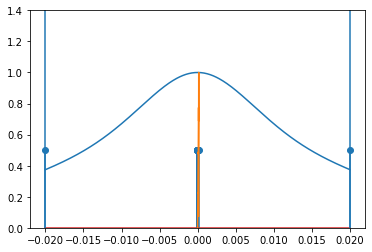

Mean, Max, Min/Max, std/Max
0.6860, 1.0000, 0.3744, 0.2059


In [194]:
y_rad = lambertian_1d(xarr, source, s, H)
y_rad = y_rad/y_rad.max()
fig = plt.figure()
ax = fig.add_subplot()
ax.stem(source, 0.5*np.ones(len(source)))
ax.plot(xarr, y_rad)
ax.axvline(-W/2)
ax.axvline(W/2)
ax.plot(t_sample, sig_low/sig_low.max())
ax.set_ylim([0, 1.4])
plt.show()

print("Mean, Max, Min/Max, std/Max")
ma = y_rad.max()
print(f"{y_rad.mean():.4f}, {ma:.4f}, {y_rad.min()/ma:.4f}, {y_rad.std()/ma:.4f}")


In [195]:
# High frequncy result
source = np.append(s_arr_high, [-W/2, W/2])

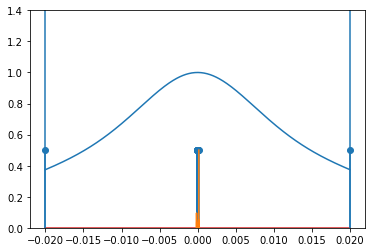

Mean, Max, Min/Max, std/Max
0.6860, 1.0000, 0.3745, 0.2059


In [197]:
y_rad = lambertian_1d(xarr, source, s, H)
y_rad = y_rad/y_rad.max()
fig = plt.figure()
ax = fig.add_subplot()
ax.stem(source, 0.5*np.ones(len(source)))
ax.plot(xarr, y_rad)
ax.axvline(-W/2)
ax.axvline(W/2)
ax.plot(t_sample, 0.5*sig_high/sig_high.max())
ax.set_ylim([0, 1.4])
plt.show()

print("Mean, Max, Min/Max, std/Max")
ma = y_rad.max()
print(f"{y_rad.mean():.4f}, {ma:.4f}, {y_rad.min()/ma:.4f}, {y_rad.std()/ma:.4f}")


In [198]:
s_arr_high[4] = 0
s_arr_high[7] = 0

In [199]:
source = np.append(s_arr_low, [-W/2, W/2])

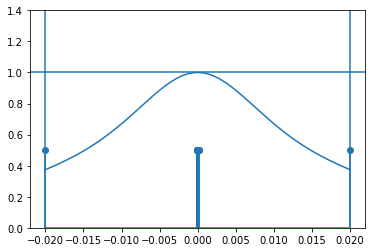

Mean, Max, Min/Max, std/Max
0.6860, 1.0000, 0.3742, 0.2059


In [201]:
y_rad = lambertian_1d(xarr, source, s, H)
y_rad = y_rad/y_rad.max()
fig = plt.figure()
ax = fig.add_subplot()
ax.stem(source, 0.5*np.ones(len(source)))
ax.plot(xarr, y_rad)
ax.axvline(-W/2)
ax.axvline(W/2)
ax.set_ylim([0, 1.4])
ax.axhline(y = 1)
plt.show()

print("Mean, Max, Min/Max, std/Max")
ma = y_rad.max()
print(f"{y_rad.mean():.4f}, {ma:.4f}, {y_rad.min()/ma:.4f}, {y_rad.std()/ma:.4f}")


---

Power weight map with number calculation.

1. Calculate power weight.
2. Normalization, Extending, Resampling.
3. Applying Low/high pass filter with band: $f_b = \frac{2 \pi}{W}$.


### Power weighting

$n$: number of the peaks after (3), 
${w_i}_{i=1}^n$: peak values.

Source location = peak location

### Distribution

Decompose into 


